# Clinical NER Model Training

This notebook prepares the BIO format data for training, builds a BiLSTM model for named entity recognition, and trains the model on the clinical notes dataset.

In [ ]:
import os
import re
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout, SpatialDropout1D

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [ ]:
# imports entity mappings from config
import sys
sys.path.append('../src')
from config import entity_to_acronyms, acronyms_to_entities

In [ ]:
data_dir = "../data"
processed_dir = os.path.join(data_dir, "processed")
bio_data_dir = os.path.join(processed_dir, "bio_data")
models_dir = os.path.join(data_dir, "models")

os.makedirs(models_dir, exist_ok=True)

## Import utility functions from src

In [5]:
import sys
sys.path.append('../src')
from data_utils import parse_bio_files, clean_word
from model import precision, recall, f1_score

## Parse BIO Files

In [ ]:
import nltk
import spacy

nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

# loads spaCy model for text processing
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    print("Downloading spaCy model...")
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

In [ ]:
# gets all BIO files
bio_files = glob.glob(os.path.join(bio_data_dir, "*.bio"))
print(f"Found {len(bio_files)} BIO files.")

Found 200 BIO files.


In [ ]:
# processes all BIO files
sentences, labels = parse_bio_files(bio_files)
print(f"Dataset contains {len(sentences)} sentences.")

20 files processed
40 files processed
60 files processed
80 files processed
100 files processed
120 files processed
140 files processed
160 files processed
180 files processed
200 files processed
Dataset contains 4541 sentences.


In [ ]:
# sample check
sample_idx = min(10, len(sentences)-1)
print("Sample sentence:", sentences[sample_idx])
print("Sample labels:", labels[sample_idx])

Sample sentence: ['crp', 'c', 'reactive', 'protein', 'be', '75', 'mgdl']
Sample labels: ['B-DIA', 'I-DIA', 'I-DIA', 'I-DIA', 'O', 'B-LAB', 'I-LAB']


## Prepare Data for Training

In [ ]:
# shuffles the data
combined = list(zip(sentences, labels))
random.shuffle(combined)
sentences, labels = zip(*combined)
sentences, labels = list(sentences), list(labels)

In [ ]:
# splits the data into training, validation, and test sets
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences, train_labels, test_size=0.1, random_state=42)

print(f"Training set size: {len(train_sentences)}")
print(f"Validation set size: {len(val_sentences)}")
print(f"Test set size: {len(test_sentences)}")

Training set size: 3268
Validation set size: 364
Test set size: 909


In [ ]:
# finds all unique labels
unique_labels = set()
for sequence in labels:
    for label in sequence:
        unique_labels.add(label)

print(f"Found {len(unique_labels)} unique labels.")
print(f"Sample labels: {list(unique_labels)[:10]}")

Found 78 unique labels.
Sample labels: ['I-AGE', 'B-BAT', 'B-FAM', 'I-NBL', 'I-FAM', 'I-ACT', 'B-OTE', 'B-DUR', 'B-DET', 'I-HEI']


In [ ]:
# creates mappings
label_to_index = {label: i for i, label in enumerate(sorted(unique_labels))}
index_to_label = {i: label for label, i in label_to_index.items()}

# adds PAD token mapping
pad_index = len(label_to_index)
label_to_index['<PAD>'] = pad_index
index_to_label[pad_index] = '<PAD>'

# saves mappings for later use
with open(os.path.join(processed_dir, 'label_mappings.json'), 'w') as f:
    json.dump({"label_to_index": label_to_index, "index_to_label": {str(k): v for k, v in index_to_label.items()}}, f)

print(f"Total labels with PAD: {len(label_to_index)}")

Total labels with PAD: 79


In [ ]:
# creates tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
all_words = [word for sentence in sentences for word in sentence]
tokenizer.fit_on_texts(all_words)
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 8429


In [ ]:
# saves the tokenizer for later use
with open(os.path.join(models_dir, 'tokenizer.pickle'), 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def prepare_sequences(sentences, labels, tokenizer, label_to_index, max_length):
    """
    Convert sentences and labels to sequences of indices and pad them.
    """
    # converts words to sequences
    X = []
    for sentence in sentences:
        sentence_seq = [tokenizer.word_index.get(word, 1) for word in sentence]  # 1 is the OOV index
        X.append(sentence_seq)
    
    # converts labels to indices
    y = []
    for label_seq in labels:
        label_indices = [label_to_index[label] for label in label_seq]
        y.append(label_indices)
    
    # pads sequences
    X_padded = pad_sequences(X, maxlen=max_length, padding='post', truncating='post')
    y_padded = pad_sequences(y, maxlen=max_length, padding='post', value=label_to_index['<PAD>'])
    
    # coverts labels to one-hot encoding
    num_classes = len(label_to_index)
    y_padded_onehot = to_categorical(y_padded, num_classes=num_classes)
    
    return X_padded, y_padded_onehot

In [ ]:
# determine max sequence length
max_length = max(len(sentence) for sentence in sentences)
print(f"Max sequence length: {max_length}")

# for performance reasons, we cap the max length
max_length = min(max_length, 100) 
print(f"Using max sequence length: {max_length}")

Max sequence length: 104
Using max sequence length: 100


In [ ]:
# prepare the data
X_train, y_train = prepare_sequences(train_sentences, train_labels, tokenizer, label_to_index, max_length)
X_val, y_val = prepare_sequences(val_sentences, val_labels, tokenizer, label_to_index, max_length)
X_test, y_test = prepare_sequences(test_sentences, test_labels, tokenizer, label_to_index, max_length)

In [ ]:
# saves processed data for future use
np.savez_compressed(
    os.path.join(processed_dir, 'processed_data.npz'),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    max_length=max_length
)

## Load Pre-trained Word Embeddings

In [ ]:
import gensim

path_to_vectors = os.path.join(data_dir, 'embedding_vectors', 'BioWordVec_PubMed_MIMICIII_d200.vec.bin')

try:
    # loads BioWordVec vectors
    biowv = gensim.models.KeyedVectors.load_word2vec_format(path_to_vectors, binary=True)
    print(f"Successfully loaded BioWordVec embeddings with {len(biowv.key_to_index)} vectors of dimension {biowv.vector_size}")
except FileNotFoundError:
    print("Warning: BioWordVec embeddings file not found at", path_to_vectors)
    print("Continuing without pre-trained embeddings. Model performance may be reduced.")
    biowv = None

Successfully loaded BioWordVec embeddings with 16545452 vectors of dimension 200


In [ ]:
# creates embedding matrix from the pre-trained vectors
embedding_dim = 200  # dimension of BioWordVec embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# if embeddings are available, populate the embedding matrix
if biowv is not None:
    for word, i in tokenizer.word_index.items():
        if word in biowv.key_to_index:
            embedding_matrix[i] = biowv[word]
    
    print(f"Created embedding matrix with shape {embedding_matrix.shape}")
    # calculates how many words from our vocabulary were found in the embeddings
    found_count = np.sum(np.sum(embedding_matrix, axis=1) != 0)
    print(f"Found {found_count}/{vocab_size-1} words in the embedding vocabulary ({found_count/(vocab_size-1)*100:.2f}%)")
else:
    print("No pre-trained embeddings available. Will use random initialization.")

Created embedding matrix with shape (8429, 200)
Found 7999/8428 words in the embedding vocabulary (94.91%)


## Define the BiLSTM Model

In [22]:
from tensorflow.keras import backend as K

def precision(y_true, y_pred):
    """
    Precision metric for multi-class classification.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """
    Recall metric for multi-class classification.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    """
    F1 score for multi-class classification.
    """
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

In [ ]:
# model parameters
INPUT_DIM = vocab_size
EMBEDDING_DIM = embedding_dim
NUM_CLASSES = len(label_to_index)
MAX_LENGTH = X_train.shape[1]

LSTM_UNITS = 64
DENSE_UNITS = 64
DROPOUT_RATE = 0.2
BATCH_SIZE = 32
EPOCHS = 20

In [ ]:
# builds the embeddings layer
if biowv is not None:
    embedding_layer = tf.keras.layers.Embedding(
        INPUT_DIM,
        EMBEDDING_DIM,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        input_length=MAX_LENGTH,
        trainable=False
    )
else:
    embedding_layer = tf.keras.layers.Embedding(
        INPUT_DIM,
        EMBEDDING_DIM,
        input_length=MAX_LENGTH,
        trainable=True
    )

/opt/anaconda3/envs/ner/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
import tensorflow as tf

# defines the model using Functional API
input_layer = tf.keras.layers.Input(shape=(MAX_LENGTH,))

# adds an embedding layer to learn the representations of words in the input text
x = embedding_layer(input_layer)

# adds a Bidirectional LSTM layer to capture contextual information from both directions
x = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(units=LSTM_UNITS, return_sequences=True)
)(x)

# adds a TimeDistributed dense layer to apply a dense layer to each time step of the LSTM output
x = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(units=DENSE_UNITS, activation='relu')
)(x)

# adds a dropout layer to reduce overfitting
x = tf.keras.layers.Dropout(rate=DROPOUT_RATE)(x)

# adds a TimeDistributed dense layer to apply a dense layer to each time step of the previous dense layer output
output_layer = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax')
)(x)

# creates the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# compiles the model
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy', precision, recall, f1_score]
)

# displays model summary
model.summary()

2025-04-06 21:55:59.043509: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-04-06 21:55:59.045081: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-06 21:55:59.045087: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-06 21:55:59.045672: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-06 21:55:59.046391: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 200)       │     1,685,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │       135,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 100, 64)        │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 100, 79)        │         5,135 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,834,871 (7.00 MB)

 Trainable params: 149,071 (582.31 KB)

 Non-trainable params: 1,685,800 (6.43 MB)

## Define Callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(models_dir, 'best_model.h5'),
    monitor='val_f1_score',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_f1_score',
    mode='max',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_f1_score',
    mode='max',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=0.0001
)

## Train the Model

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[model_checkpoint, early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20


2025-04-06 21:56:16.217177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8226 - f1_score: 0.4778 - loss: 2.0844 - precision: 0.6130 - recall: 0.4454
Epoch 1: val_f1_score improved from -inf to 0.93144, saving model to ../data/models/best_model.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 33s 238ms/step - accuracy: 0.8232 - f1_score: 0.4804 - loss: 2.0743 - precision: 0.6153 - recall: 0.4479 - val_accuracy: 0.9054 - val_f1_score: 0.9314 - val_loss: 0.3869 - val_precision: 0.9761 - val_recall: 0.8907 - learning_rate: 0.0010
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9108 - f1_score: 0.9321 - loss: 0.3805 - precision: 0.9808 - recall: 0.8881
Epoch 2: val_f1_score improved from 0.93144 to 0.93546, saving model to ../data/models/best_model.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 199ms/step - accuracy: 0.9108 - f1_score: 0.9321 - loss: 0.3804 - precision: 0.9808 - recall: 0.8881 - val_accuracy: 0.9203 - val_f1_score: 0.9355 - val_loss: 0.3178 - val_precision: 0.9828 - val_recall: 0.8925 - learning_rate: 0.0010
Epoch 3/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9209 - f1_score: 0.9359 - loss: 0.3183 - precision: 0.9825 - recall: 0.8936
Epoch 3: val_f1_score improved from 0.93546 to 0.93880, saving model to ../data/models/best_model.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - accuracy: 0.9209 - f1_score: 0.9359 - loss: 0.3182 - precision: 0.9825 - recall: 0.8936 - val_accuracy: 0.9288 - val_f1_score: 0.9388 - val_loss: 0.2756 - val_precision: 0.9827 - val_recall: 0.8987 - learning_rate: 0.0010
Epoch 4/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9278 - f1_score: 0.9390 - loss: 0.2802 - precision: 0.9804 - recall: 0.9009
Epoch 4: val_f1_score improved from 0.93880 to 0.94336, saving model to ../data/models/best_model.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.9278 - f1_score: 0.9390 - loss: 0.2802 - precision: 0.9804 - recall: 0.9009 - val_accuracy: 0.9345 - val_f1_score: 0.9434 - val_loss: 0.2505 - val_precision: 0.9818 - val_recall: 0.9078 - learning_rate: 0.0010
Epoch 5/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9331 - f1_score: 0.9419 - loss: 0.2553 - precision: 0.9791 - recall: 0.9074
Epoch 5: val_f1_score improved from 0.94336 to 0.94604, saving model to ../data/models/best_model.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - accuracy: 0.9331 - f1_score: 0.9419 - loss: 0.2553 - precision: 0.9790 - recall: 0.9074 - val_accuracy: 0.9384 - val_f1_score: 0.9460 - val_loss: 0.2328 - val_precision: 0.9806 - val_recall: 0.9138 - learning_rate: 0.0010
Epoch 6/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9368 - f1_score: 0.9444 - loss: 0.2367 - precision: 0.9787 - recall: 0.9126
Epoch 6: val_f1_score improved from 0.94604 to 0.94756, saving model to ../data/models/best_model.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 0.9368 - f1_score: 0.9444 - loss: 0.2367 - precision: 0.9786 - recall: 0.9126 - val_accuracy: 0.9402 - val_f1_score: 0.9476 - val_loss: 0.2215 - val_precision: 0.9784 - val_recall: 0.9187 - learning_rate: 0.0010
Epoch 7/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9404 - f1_score: 0.9469 - loss: 0.2226 - precision: 0.9783 - recall: 0.9174
Epoch 7: val_f1_score improved from 0.94756 to 0.94921, saving model to ../data/models/best_model.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - accuracy: 0.9404 - f1_score: 0.9469 - loss: 0.2226 - precision: 0.9783 - recall: 0.9174 - val_accuracy: 0.9423 - val_f1_score: 0.9492 - val_loss: 0.2118 - val_precision: 0.9786 - val_recall: 0.9216 - learning_rate: 0.0010
Epoch 8/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9423 - f1_score: 0.9484 - loss: 0.2126 - precision: 0.9779 - recall: 0.9206
Epoch 8: val_f1_score improved from 0.94921 to 0.94981, saving model to ../data/models/best_model.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 189ms/step - accuracy: 0.9423 - f1_score: 0.9484 - loss: 0.2126 - precision: 0.9779 - recall: 0.9206 - val_accuracy: 0.9435 - val_f1_score: 0.9498 - val_loss: 0.2057 - val_precision: 0.9771 - val_recall: 0.9240 - learning_rate: 0.0010
Epoch 9/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9447 - f1_score: 0.9502 - loss: 0.2031 - precision: 0.9778 - recall: 0.9242
Epoch 9: val_f1_score improved from 0.94981 to 0.95125, saving model to ../data/models/best_model.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - accuracy: 0.9447 - f1_score: 0.9502 - loss: 0.2031 - precision: 0.9778 - recall: 0.9242 - val_accuracy: 0.9452 - val_f1_score: 0.9512 - val_loss: 0.1999 - val_precision: 0.9771 - val_recall: 0.9267 - learning_rate: 0.0010
Epoch 10/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9465 - f1_score: 0.9515 - loss: 0.1944 - precision: 0.9774 - recall: 0.9270
Epoch 10: val_f1_score improved from 0.95125 to 0.95161, saving model to ../data/models/best_model.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - accuracy: 0.9465 - f1_score: 0.9515 - loss: 0.1945 - precision: 0.9774 - recall: 0.9270 - val_accuracy: 0.9460 - val_f1_score: 0.9516 - val_loss: 0.1962 - val_precision: 0.9763 - val_recall: 0.9281 - learning_rate: 0.0010
Epoch 11/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9481 - f1_score: 0.9527 - loss: 0.1884 - precision: 0.9774 - recall: 0.9291
Epoch 11: val_f1_score improved from 0.95161 to 0.95189, saving model to ../data/models/best_model.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - accuracy: 0.9481 - f1_score: 0.9527 - loss: 0.1884 - precision: 0.9774 - recall: 0.9291 - val_accuracy: 0.9468 - val_f1_score: 0.9519 - val_loss: 0.1930 - val_precision: 0.9756 - val_recall: 0.9293 - learning_rate: 0.0010
Epoch 12/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9495 - f1_score: 0.9538 - loss: 0.1824 - precision: 0.9777 - recall: 0.9310
Epoch 12: val_f1_score improved from 0.95189 to 0.95264, saving model to ../data/models/best_model.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - accuracy: 0.9495 - f1_score: 0.9538 - loss: 0.1824 - precision: 0.9777 - recall: 0.9310 - val_accuracy: 0.9478 - val_f1_score: 0.9526 - val_loss: 0.1893 - val_precision: 0.9748 - val_recall: 0.9315 - learning_rate: 0.0010
Epoch 13/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9505 - f1_score: 0.9546 - loss: 0.1768 - precision: 0.9774 - recall: 0.9328
Epoch 13: val_f1_score improved from 0.95264 to 0.95319, saving model to ../data/models/best_model.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 189ms/step - accuracy: 0.9505 - f1_score: 0.9546 - loss: 0.1768 - precision: 0.9774 - recall: 0.9328 - val_accuracy: 0.9475 - val_f1_score: 0.9532 - val_loss: 0.1881 - val_precision: 0.9747 - val_recall: 0.9326 - learning_rate: 0.0010
Epoch 14/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9516 - f1_score: 0.9557 - loss: 0.1720 - precision: 0.9775 - recall: 0.9347
Epoch 14: val_f1_score improved from 0.95319 to 0.95368, saving model to ../data/models/best_model.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - accuracy: 0.9516 - f1_score: 0.9557 - loss: 0.1720 - precision: 0.9775 - recall: 0.9347 - val_accuracy: 0.9478 - val_f1_score: 0.9537 - val_loss: 0.1868 - val_precision: 0.9743 - val_recall: 0.9339 - learning_rate: 0.0010
Epoch 15/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9529 - f1_score: 0.9564 - loss: 0.1674 - precision: 0.9776 - recall: 0.9362
Epoch 15: val_f1_score improved from 0.95368 to 0.95400, saving model to ../data/models/best_model.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - accuracy: 0.9529 - f1_score: 0.9564 - loss: 0.1674 - precision: 0.9776 - recall: 0.9362 - val_accuracy: 0.9486 - val_f1_score: 0.9540 - val_loss: 0.1841 - val_precision: 0.9741 - val_recall: 0.9348 - learning_rate: 0.0010
Epoch 16/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9539 - f1_score: 0.9573 - loss: 0.1620 - precision: 0.9778 - recall: 0.9376
Epoch 16: val_f1_score improved from 0.95400 to 0.95442, saving model to ../data/models/best_model.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - accuracy: 0.9539 - f1_score: 0.9573 - loss: 0.1620 - precision: 0.9778 - recall: 0.9376 - val_accuracy: 0.9492 - val_f1_score: 0.9544 - val_loss: 0.1833 - val_precision: 0.9742 - val_recall: 0.9355 - learning_rate: 0.0010
Epoch 17/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9545 - f1_score: 0.9582 - loss: 0.1580 - precision: 0.9778 - recall: 0.9394
Epoch 17: val_f1_score did not improve from 0.95442
103/103 ━━━━━━━━━━━━━━━━━━━━ 18s 174ms/step - accuracy: 0.9545 - f1_score: 0.9582 - loss: 0.1580 - precision: 0.9778 - recall: 0.9394 - val_accuracy: 0.9490 - val_f1_score: 0.9543 - val_loss: 0.1840 - val_precision: 0.9734 - val_recall: 0.9359 - learning_rate: 0.0010
Epoch 18/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9557 - f1_score: 0.9586 - loss: 0.1545 - precision: 0.9780 - recall: 0.9399
Epoch 18: val_f1_score did not improve from 0.95442

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237

103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - accuracy: 0.9567 - f1_score: 0.9599 - loss: 0.1499 - precision: 0.9786 - recall: 0.9419 - val_accuracy: 0.9505 - val_f1_score: 0.9554 - val_loss: 0.1802 - val_precision: 0.9738 - val_recall: 0.9376 - learning_rate: 5.0000e-04
Epoch 20/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9574 - f1_score: 0.9604 - loss: 0.1468 - precision: 0.9789 - recall: 0.9426
Epoch 20: val_f1_score did not improve from 0.95539
103/103 ━━━━━━━━━━━━━━━━━━━━ 18s 174ms/step - accuracy: 0.9574 - f1_score: 0.9604 - loss: 0.1468 - precision: 0.9788 - recall: 0.9426 - val_accuracy: 0.9504 - val_f1_score: 0.9554 - val_loss: 0.1803 - val_precision: 0.9730 - val_recall: 0.9384 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 19.


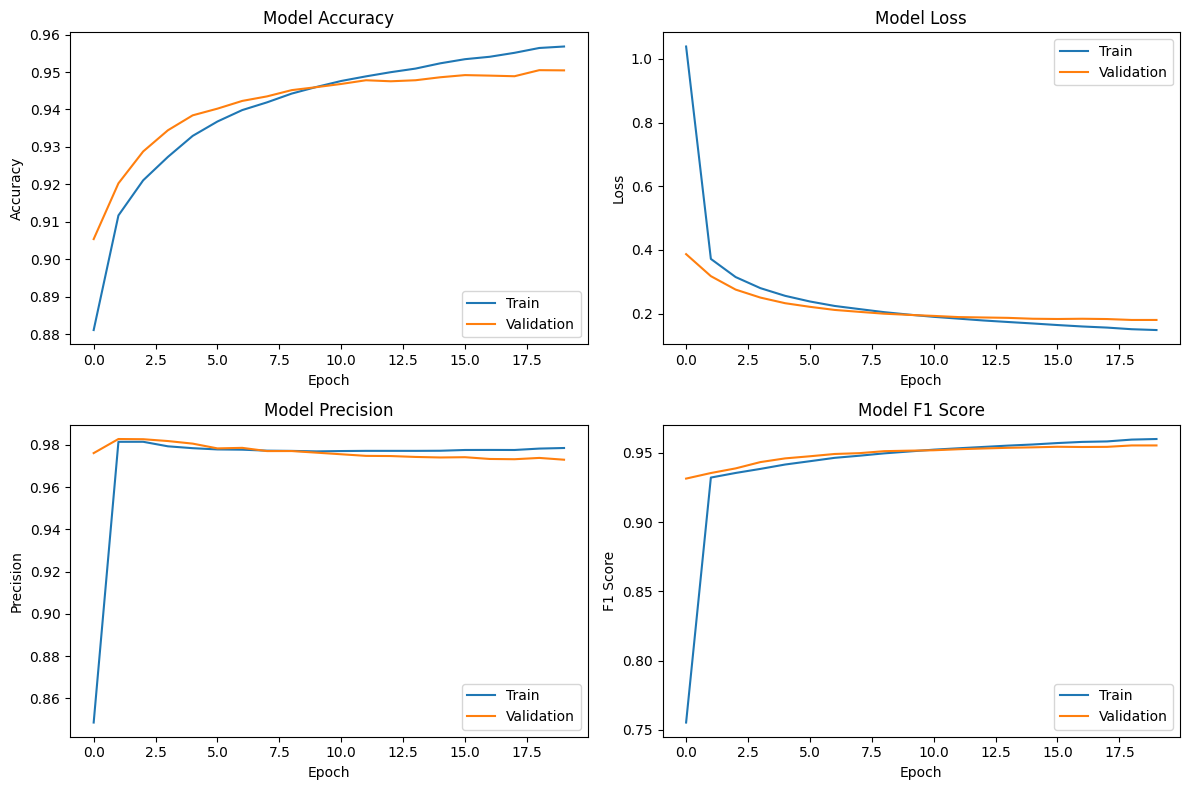

In [ ]:
# plots training history
def plot_graphs(history):
    plt.figure(figsize=(12, 8))
    
    # plots accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    # plots loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    # plots precision
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    # plots F1 score
    plt.subplot(2, 2, 4)
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    plt.tight_layout()
    plt.savefig(os.path.join(models_dir, 'training_history.png'))
    plt.show()

plot_graphs(history)

## Evaluate the Model

In [ ]:
# loads the best model
model.load_weights(os.path.join(models_dir, 'best_model.h5'))

# evaluates on the test set
test_loss, test_accuracy, test_precision, test_recall, test_f1 = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9507 - f1_score: 0.9556 - loss: 0.1824 - precision: 0.9741 - recall: 0.9379
Test Loss: 0.1849
Test Accuracy: 0.9495
Test Precision: 0.9729
Test Recall: 0.9366
Test F1 Score: 0.9544


In [ ]:
# generates classification report
def generate_classification_report(model, X_test, y_test, index_to_label):
    # gets model predictions
    y_pred = model.predict(X_test)
    
    # coverts one-hot encoded predictions and labels to class indices
    y_pred_indices = np.argmax(y_pred, axis=2).flatten()
    y_true_indices = np.argmax(y_test, axis=2).flatten()
    
    # creates a mask to filter out padding
    mask = y_true_indices != label_to_index['<PAD>']
    
    # applies mask
    y_pred_indices = y_pred_indices[mask]
    y_true_indices = y_true_indices[mask]
    
    # converts indices to labels
    y_pred_labels = [index_to_label[idx] for idx in y_pred_indices]
    y_true_labels = [index_to_label[idx] for idx in y_true_indices]
    
    # generates and print the classification report
    report = classification_report(y_true_labels, y_pred_labels, zero_division=0)
    print(report)
    
    # saves report as text file
    with open(os.path.join(models_dir, 'classification_report.txt'), 'w') as f:
        f.write(report)
    
    return y_true_labels, y_pred_labels

y_true_labels, y_pred_labels = generate_classification_report(model, X_test, y_test, index_to_label)

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step
              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00         0
       B-ACT       0.75      0.14      0.24        21
       B-ADM       0.53      0.74      0.62        23
       B-AGE       0.93      0.98      0.95        42
       B-ARA       0.00      0.00      0.00        10
       B-BAT       0.00      0.00      0.00         1
       B-BST       0.68      0.70      0.69       520
       B-CLE       0.79      0.76      0.77       133
       B-COL       0.38      0.50      0.43         6
       B-COR       0.30      0.05      0.09        57
       B-DAT       0.74      0.71      0.72       138
       B-DET       0.37      0.42      0.39       475
       B-DIA       0.72      0.73      0.73       794
       B-DIS       0.45      0.50      0.47       246
       B-DOS       0.50      0.68      0.58        50
       B-DUR       0.36      0.52      0.43        63
       B-FAM       0.50      0.05      0

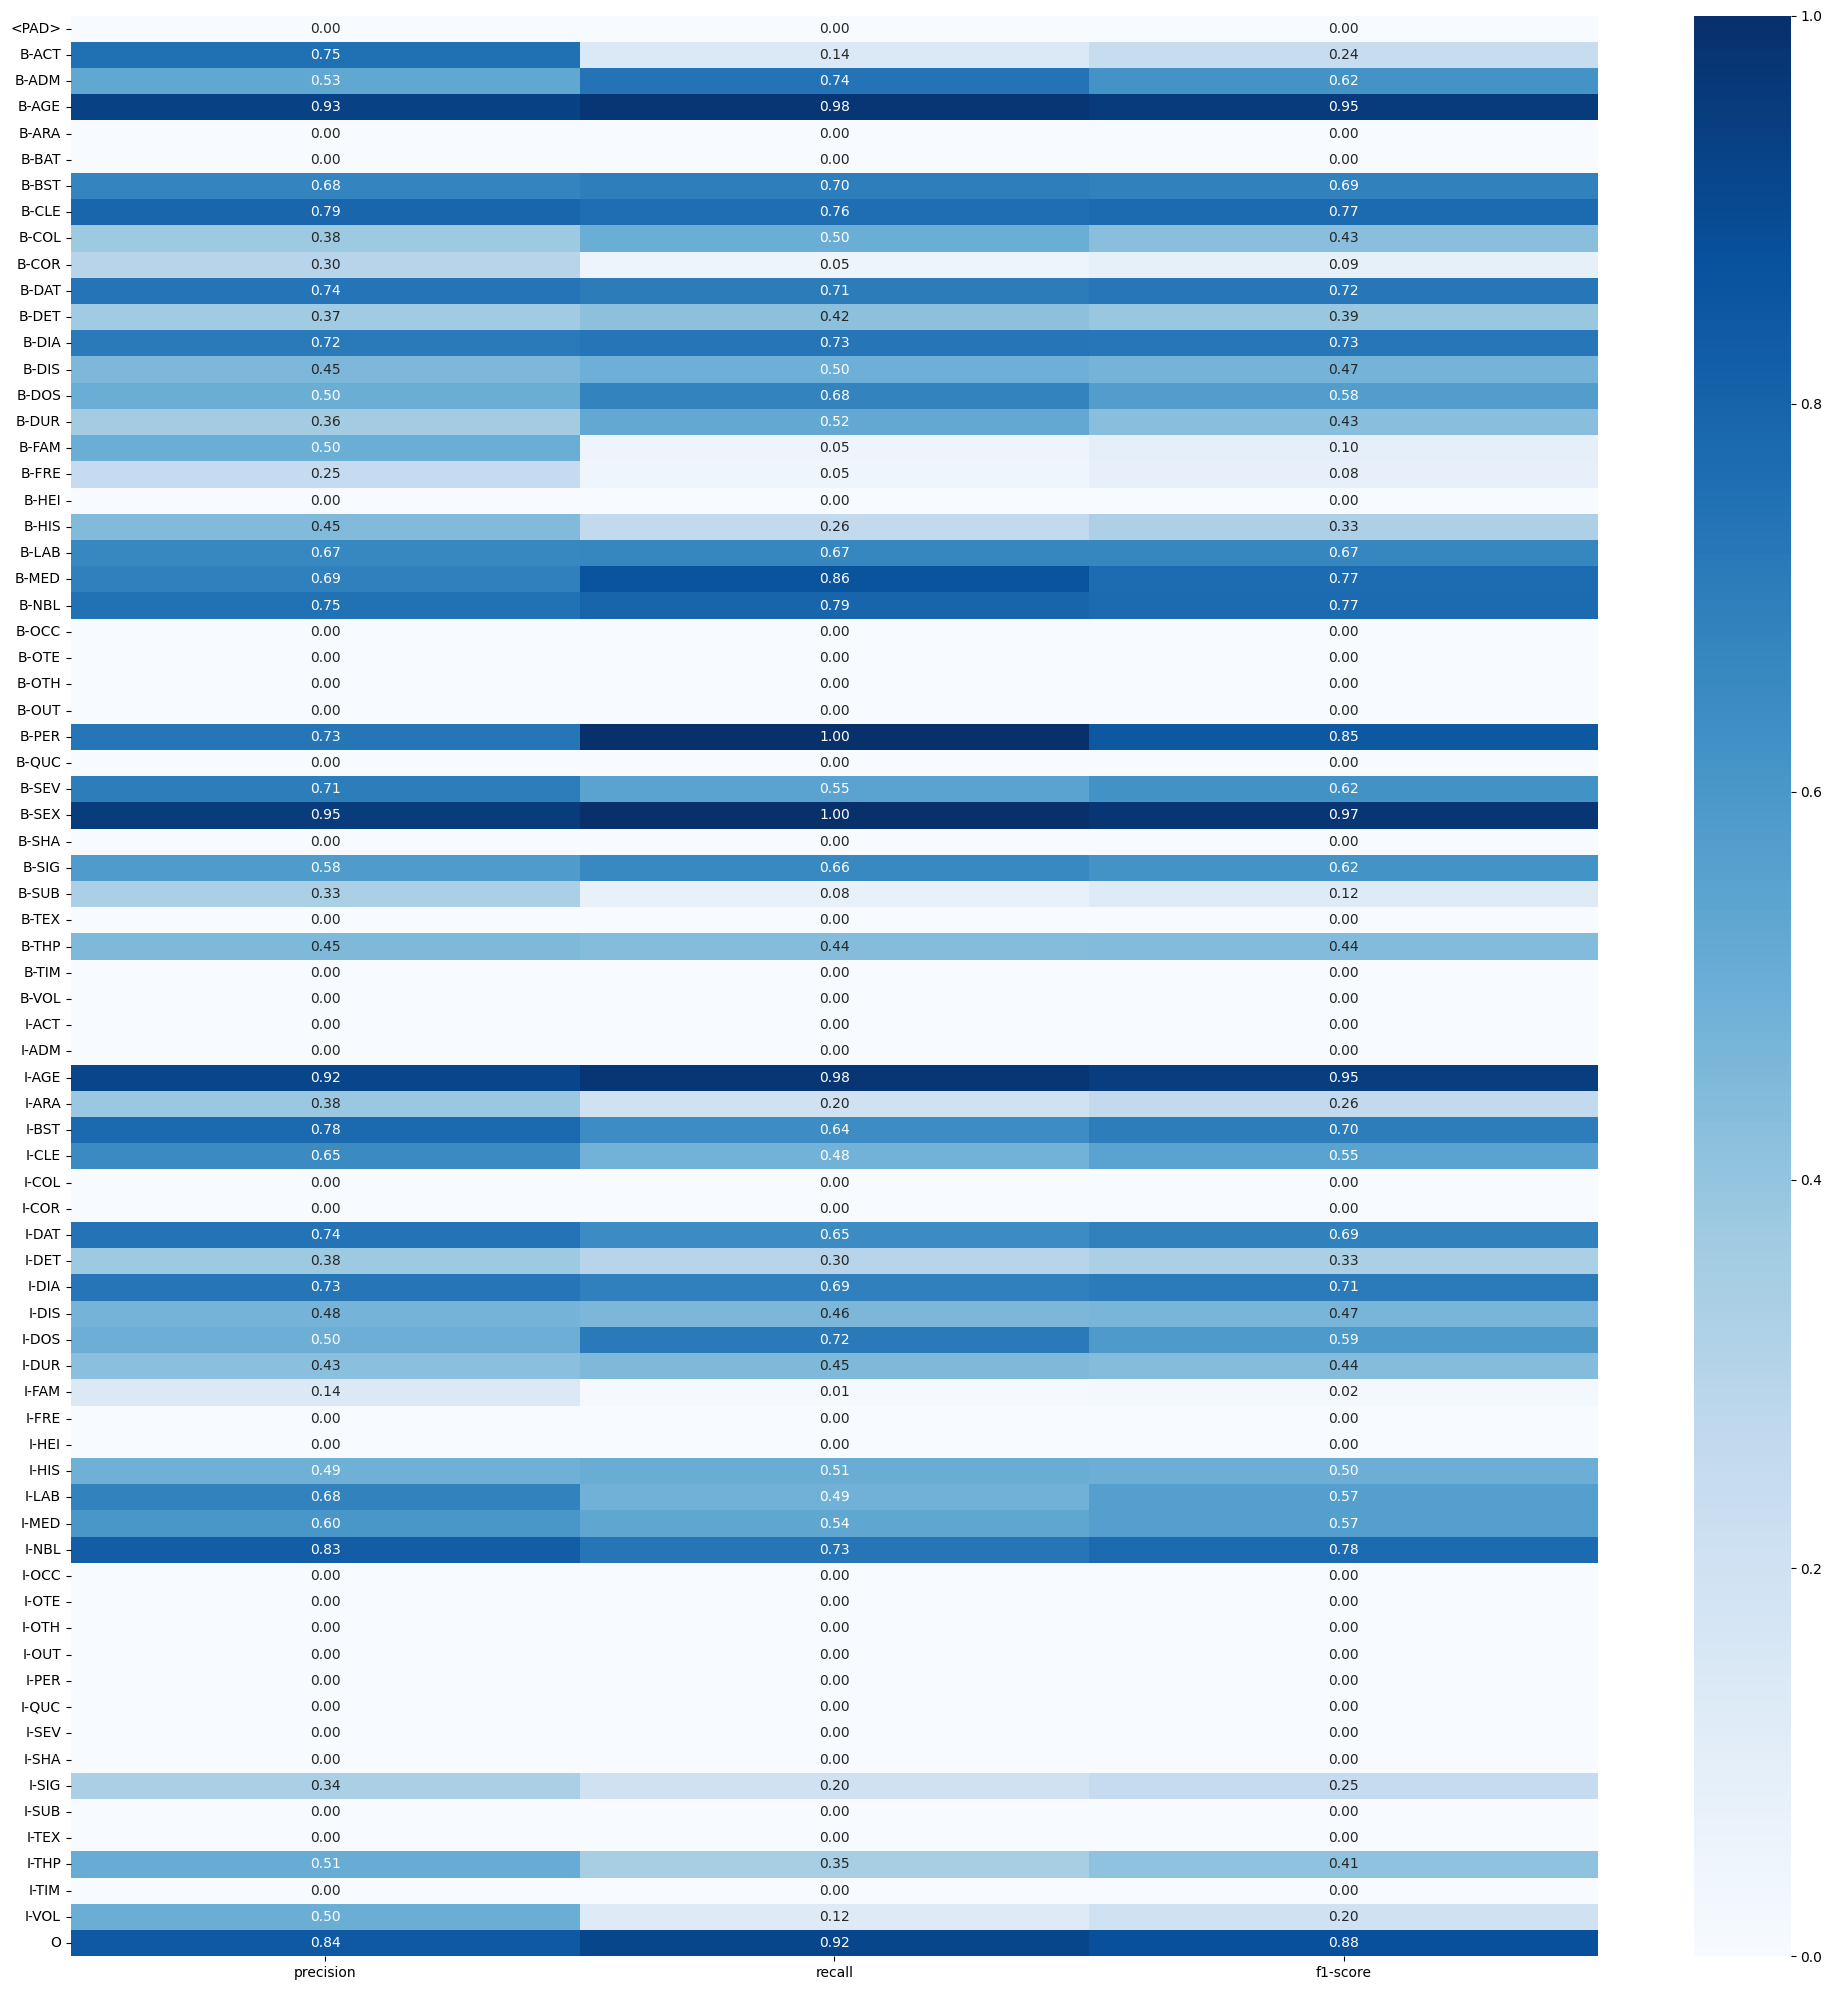

In [ ]:
# creates a confusion matrix heatmap for the most common labels
import seaborn as sns
import pandas as pd

# coverts to DataFrame for easier visualization
report_dict = classification_report(y_true_labels, y_pred_labels, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).T

# plots heatmap of metrics for each label
plt.figure(figsize=(20, 20))
sns.heatmap(report_df.iloc[:-3, :3], annot=True, cmap='Blues', fmt='.2f')
plt.tight_layout()
plt.savefig(os.path.join(models_dir, 'classification_report.png'))
plt.show()

## Save the model and metadata

In [ ]:
# saves model and all necessary files for inference
model.save(os.path.join(models_dir, 'ner_model.h5'))

# saves model metadata
model_metadata = {
    'max_length': max_length,
    'vocab_size': vocab_size,
    'num_classes': NUM_CLASSES,
    'label_to_index': label_to_index,
    'index_to_label': {str(k): v for k, v in index_to_label.items()},
    'performance': {
        'test_accuracy': float(test_accuracy),
        'test_precision': float(test_precision),
        'test_recall': float(test_recall),
        'test_f1': float(test_f1)
    }
}

with open(os.path.join(models_dir, 'model_metadata.json'), 'w') as f:
    json.dump(model_metadata, f)

print(f"Model and metadata saved to {models_dir}.")

Model and metadata saved to ../data/models.


## Test model with example predictions

In [ ]:
# imports the prediction function from our utilities
from data_utils import predict

In [ ]:
# tests on a sample clinical text
test_text = "The patient underwent an electrophysiologic study with mapping of the accessory pathway, followed by radiofrequency ablation (interruption of the pathway using the heat generated by electromagnetic waves at the tip of an ablation catheter)."

predict(
    test_text,
    model, 
    index_to_label,
    acronyms_to_entities, 
    max_length
)

## Summary

In this notebook, we've:
1. Loaded and processed the BIO format data
2. Built a BiLSTM model for named entity recognition
3. Trained the model and achieved good performance on the test set
4. Evaluated the model using standard NER metrics
5. Saved the model and necessary metadata for inference

The trained model can now be used for entity recognition in clinical text.